In [1]:
%matplotlib inline

# standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcs

# plot style 
from jupyterthemes import jtplot
jtplot.style()

# useful imports
from sklearn.metrics import pairwise_distances, pairwise_distances_argmin
from sklearn.cluster import KMeans

# fix a long enough list of colors (one for each cluster)
cmap = [ mcs.to_rgb(c) for c in plt.get_cmap('tab20').colors ]
cmap.extend([ mcs.to_rgb(c) for c in plt.get_cmap('tab20b').colors ] )
cmap.extend([ mcs.to_rgb(c) for c in plt.get_cmap('tab20c').colors ] )

# useful lambda terms
to_hours = lambda x : float( \
    ((type(x) is pd.Timedelta) and (x.days*24.0 + ((x.seconds/60)/60))) or \
     ((type(x) is pd.Timestamp) and ((x.dayofyear-1)*24 + x.hour + x.minute/60)))

conve = lambda ii : \
    lambda x : (ii, x)

# define some useful time ranges
tics = pd.Series(np.linspace(0, 23.5, 48))
days = pd.date_range('2013-01-01', '2013-12-31', freq='1D').map(to_hours)



# Behavior of Sample Paths

### Load Observed Time-Series
Load and re-index thresholded pool of time-series observations 

In [2]:
# load sample paths
data = pd.read_pickle('./pickle/2013-10x90-samp.pkl')

# extract observation times (in hours) 
#       ... relatvie to first obs.
times = (data.index - data.index[0]).map(to_hours)

# change index to 'times'
data.set_index( times, inplace=True )


### Extracting New Features 
 We will be transforming the sample-paths into vectors which have the nice property that the squared euclidean norm $\lVert x \rVert^2$ has the form 
$$ \lVert y\rVert^2 + \sum_{k=1}^H\lVert \mathcal{L_k} y \rVert^2 $$
where each $\mathcal{L_k}$ is a linear operator acting on $y$ and $y$ is equal to $x\vert_I$ for some subset $I$ of indicies. 

#### Finite-Differences

In our case, we want $\mathcal{L}_k = (\Delta)^k$, where $\Delta$ is the standard forward-difference operator mapping $v\in\mathbb{R}^K$ to
   $$\Delta v = \langle (t_{i+1}-t_{i})^{-1}(v_{i+1}-v_{i}) : i < K\rangle \in \mathbb{R}^{K-1}$$
 and for some fixed $n\in\mathbb{N}$, $y = x\vert_{[0,n)}$ is a member of our sample space.

To construct these vectors, we proceed as follows

In [3]:
H = 3 # highest order FD to calculate

# initialize segment dict and calculate time-steps 
segment = dict.fromkeys( range(H), None ) 

# begin recursion
segment[0] = data
for ii in range(H-1):
    # calculate time-steps
    dt = np.diff(segment[ii].index)
    
    # calculate forward-difference
    segment[ii+1] = \
        (segment[ii].diff(-1).\
            drop(index=segment[ii].index[-1])).\
                apply( lambda x : x/dt )
    

#### Combine  Segments

Merging the segments togther, we use an appropriate `pd.MultiIndex` to seperate out the images under the FD operator.

In [303]:
# add segment number to indices
for ii in range(H):
    segment[ii].rename(index=conve(ii), inplace=True)

# combine segments
sobolev = pd.concat( segment.values(), axis=0 ).\
    transpose()

# build MultiIndex
sobolev.set_axis( 
    pd.MultiIndex.from_tuples(
        sobolev.columns, 
        sortorder=2, 
        names=['order', 't']),
    axis=1,
    inplace=True)


### K-means Clustering

We're going to apply K-means to the sobolev vectors we just constructed; so we single out a set of days to consider, then extract the readings corresponding those days; using those projected vectors as the training set.

In [305]:
# select days for training set

samp = np.random.choice(days)
samp = samp + np.arange(-4,5) * (days[1]/4)

# convert generate list of relevant times 
train_days = [d + tics for d in samp ]
train_times = pd.concat([d + tics for d in samp ])

# extract training data
train = sobolev.loc[:, (range(H),train_times) ].dropna()

#### Compute Cluster Centers

In [246]:

K = 10 # number of clusters
N = len(train_days) # number of models to fit

# parameters 
params = dict(
    n_clusters=K,
    tol=1e-10,
    init='k-means++', n_init=10, max_iter=300,
    algorithm='auto',
    random_state=None, verbose=1, n_jobs=3,
    precompute_distances='auto', copy_x=True)

# initialize 'N' k-means instances
kobjs = map(lambda x : KMeans(**params), range(N))

# train the models
centers = []
for n, k in enumerate(kobjs):
    # apply K-means on n'th training partition.
    k.fit(train.loc[:,(range(H), train_days[n])]) 
    centers.append( # store cluster centers
        k.cluster_centers_)
    display(k)      # indicate fitting is done


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=3, precompute_distances='auto',
       random_state=None, tol=1e-10, verbose=1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=3, precompute_distances='auto',
       random_state=None, tol=1e-10, verbose=1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=3, precompute_distances='auto',
       random_state=None, tol=1e-10, verbose=1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=3, precompute_distances='auto',
       random_state=None, tol=1e-10, verbose=1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=3, precompute_distances='auto',
       random_state=None, tol=1e-10, verbose=1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=3, precompute_distances='auto',
       random_state=None, tol=1e-10, verbose=1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=3, precompute_distances='auto',
       random_state=None, tol=1e-10, verbose=1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=3, precompute_distances='auto',
       random_state=None, tol=1e-10, verbose=1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=3, precompute_distances='auto',
       random_state=None, tol=1e-10, verbose=1)

#### Order Centers According to Cluster Size

In [265]:
# def 'region' 
region = train.copy()
labels = pd.DataFrame(columns=np.arange(0,N))
# score region
for ii, c in enumerate(centers):
    # assign each path a label according to it's nearest k-means center.
    vecs = train.loc[:, (range(H), train_days[ii])]
    tmp = pd.Series(
        pairwise_distances_argmin(vecs, c),
        index=vecs.index)
    
    # order by centers by cluster size
    szorder = list(tmp.value_counts().index) # size ordering
    centers[ii] = c[szorder] # apply order to centers
    
    # update and store path labels 
    labels[ii]=tmp.apply(szorder.index)
    pass

## Analysis of Clusters
First, lets setup some tools to enable our analysis

In [307]:
# some housekeeping
ids = list(range(K))

# some summary info for each cluster
cluster = pd.DataFrame(
    index=pd.MultiIndex.from_product(
        [range(N), ids], names=['N', 'K']))

root = cluster.copy()

cluster.sort_index(inplace=True)
cluster['sz'] = ""
cluster['members'] = ""

# store cluster sizes and set of members
for ii in range(N):
    cluster.loc[:,'sz'] = cluster.index.\
        map(lambda x : \
            labels[x[0]].value_counts()[x[1]])
    
    cluster.loc[:,'members'] = cluster.index.\
            map(lambda x : \
                  set(labels[x[0]].\
                          where(labels[x[0]] == x[1]).dropna().index))

### Conditional Expectation of $X_t$ and $\Delta X_t$ 
To begin let's look at the conditional expectations and variances,

KeyError: 0

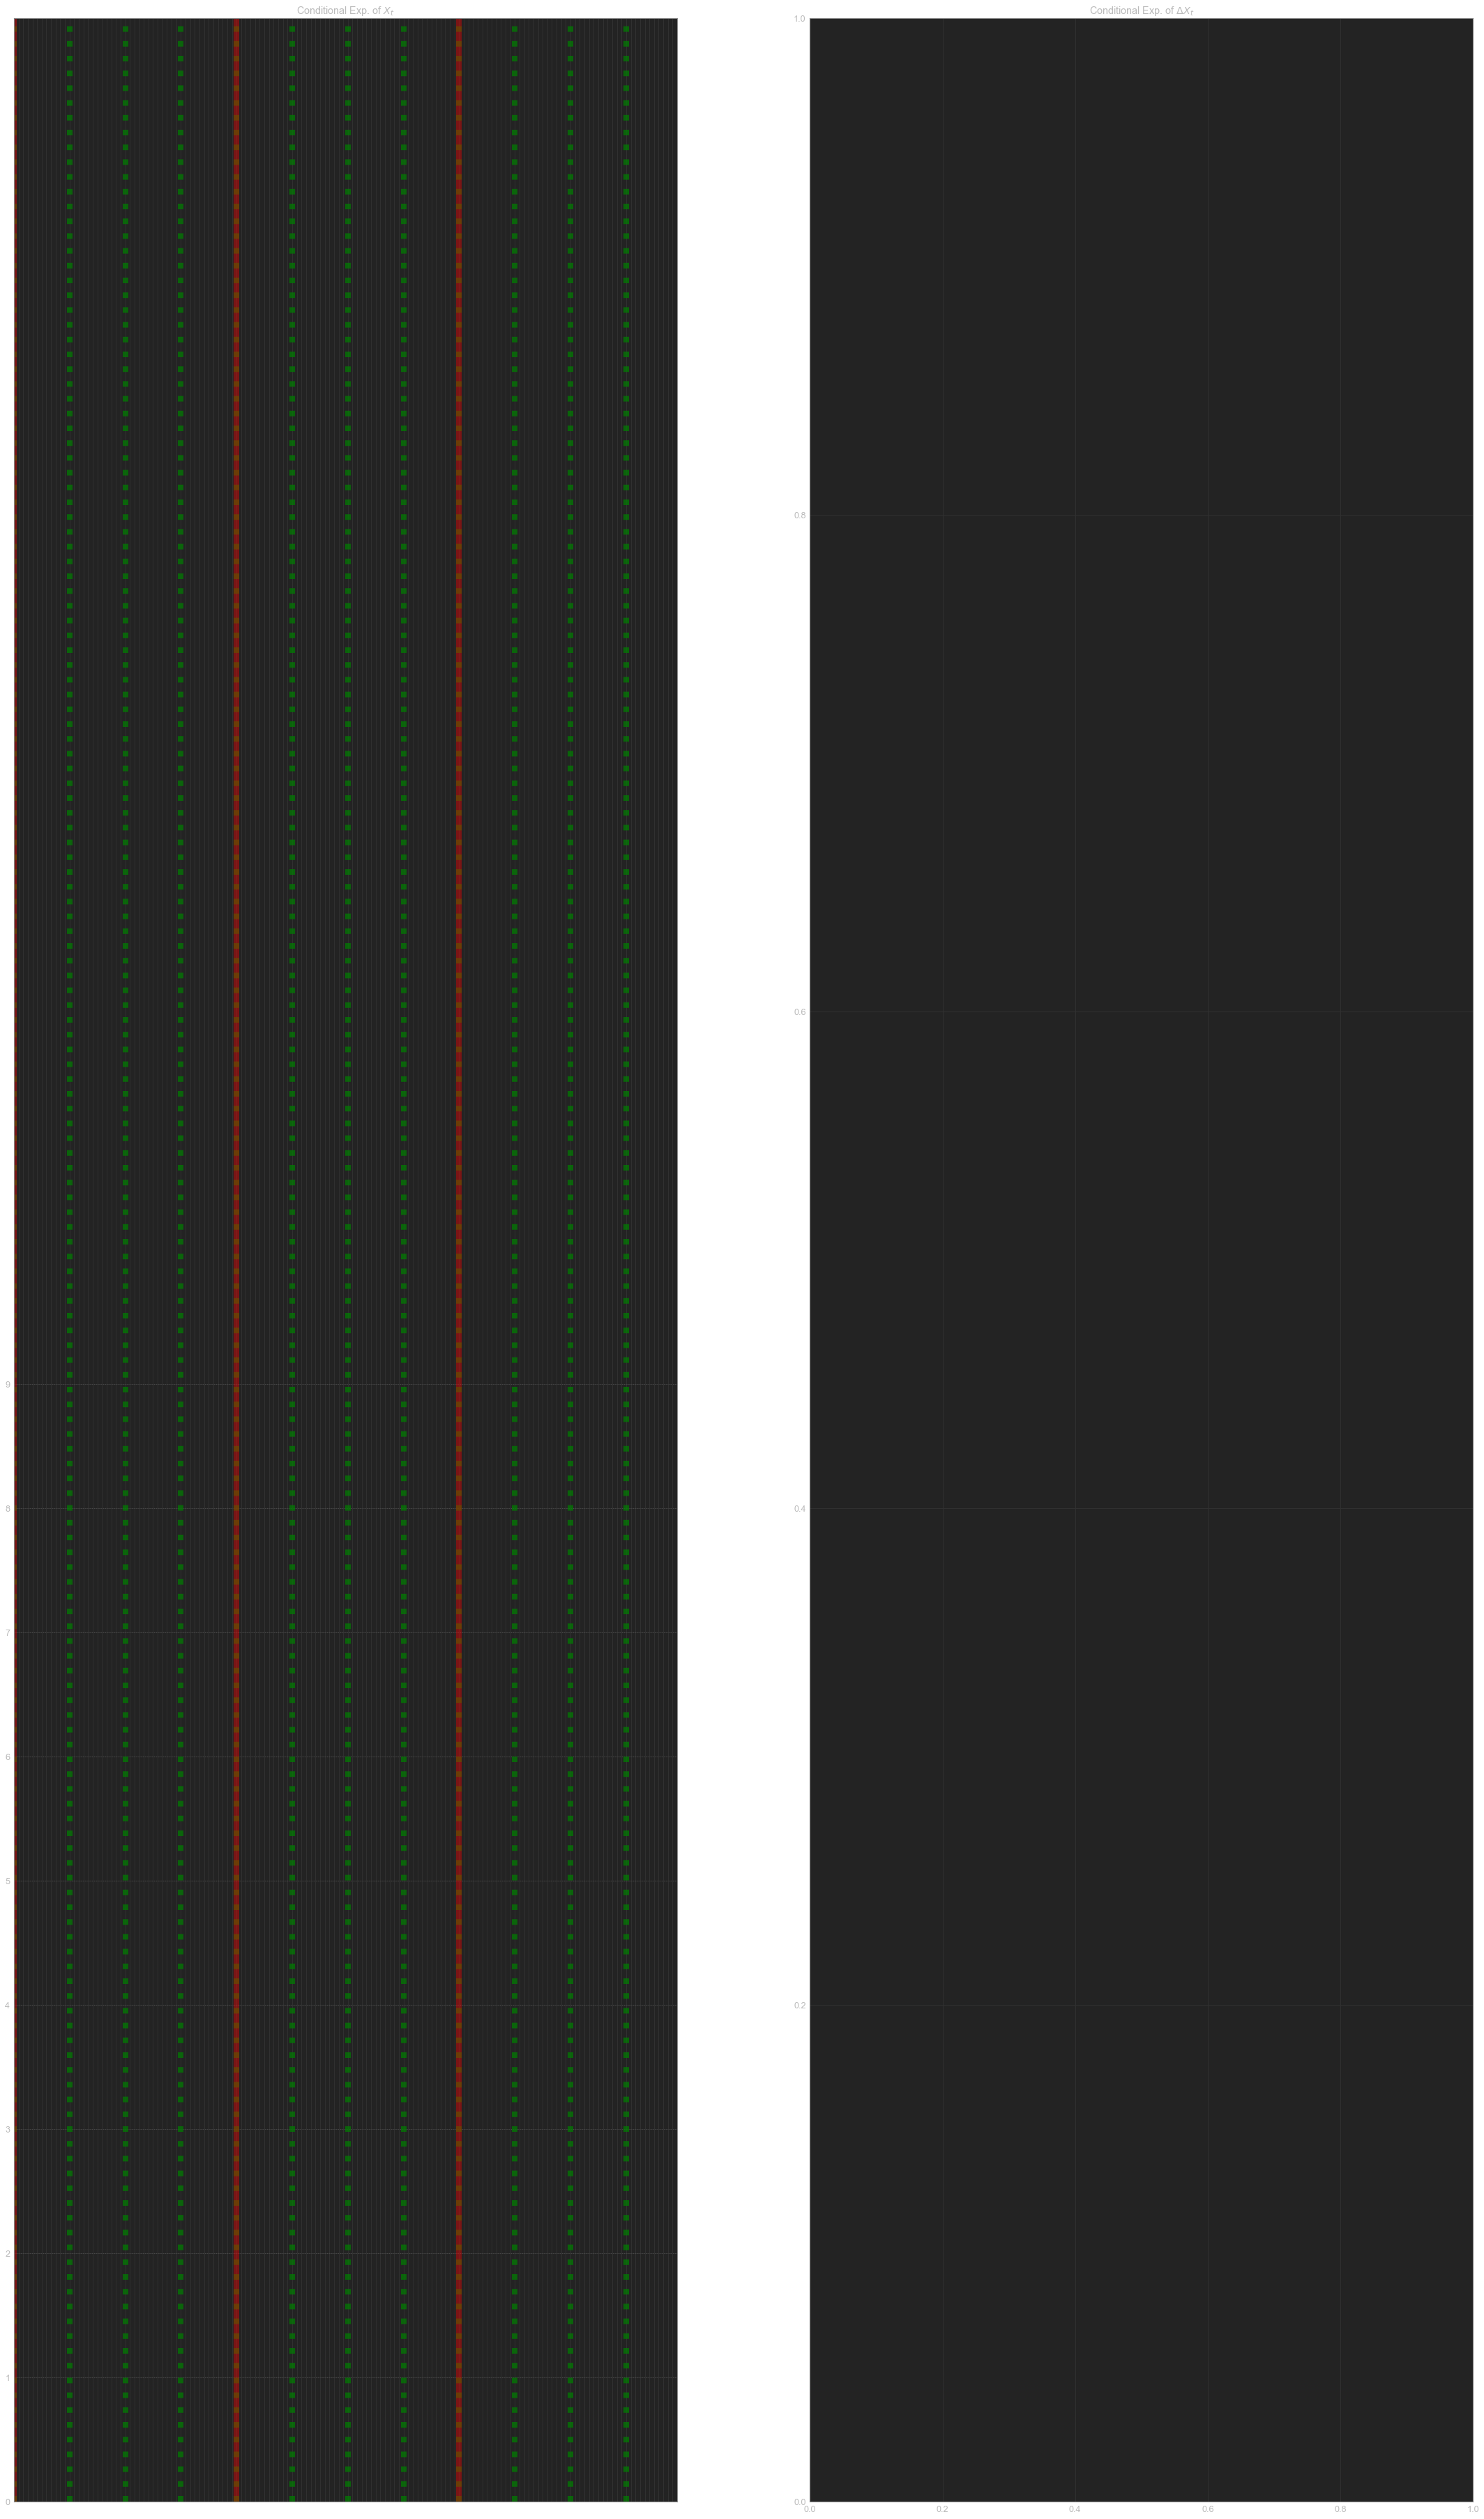

In [309]:

fig, means = plt.subplots(1, 2)
fig.set_size_inches(12.5 * H, 65.5)

means[0].set_title('Conditional Exp. of $X_t$')
means[1].set_title('Conditional Exp. of $\Delta X_t$')

rho = 2
for j0, t in enumerate(means):
    t0 = train_times-min(train_times)
    s0 = set([x.min()-min(samp) for x in train_days ])
    s0 = s0.union([x+days[1] for x in s0])
    d0 = days[days.map(lambda d: d in samp)] - min(train_times)
    
    ymax = rho*(max(ids)+1); ymin = rho*min(ids)
    xmax = max(t0);          xmin = min(t0)
    
    t.set_xlim(xmin, xmax); t.set_xticks(t0);  t.set_xticklabels([]);
    t.set_ylim(ymin, ymax); t.set_yticks(ids);
    
    t.hlines( list(ids), xmin, xmax, linestyle=':', color='gray',  alpha=0.3)
    t.vlines( list(s0),  ymin, ymax, linestyle=':', color='green', linewidth=8, alpha=0.7)
    t.vlines( list(d0),  ymin, ymax,                color='red',   linewidth=8, alpha=0.4)
    
    for k0 in ids:
        offset = rho*k0        
        for i0 in range(N):
            members = cluster.loc[(i0,k0),].members
            values = region.loc[members,(j0, train_days[i0])]
            # expected value conditioned on cluster label
            mu = values[j0].mean()
            t0 = mu.index.values - samp[j0]
            
            t.plot( t0, mu.values + offset, color='c' )
            for idx, path in values[j0].sample(1+min(10, len(members)-1)).iterrows():
                if i0 > 0:
                    c = cmap[ labels.loc[idx,i0-1] ]
                else:
                    c = cmap[k0]
                
                t.scatter( t0, path.values + offset, color=[c], alpha=0.6)
            

fig.tight_layout()
fig.savefig('expect.png')

### Conditional Distribution of Readings

 Fix bins for each segment of `sobolev`

In [60]:
bins = [np.linspace(0, 1, 101), 
        np.linspace(-2, 2, 101)]

Compute and store histograms

In [62]:
# returns the histogram 
frag = lambda x : \
   [ (np.histogram(region.loc[x.members,order].stack().dropna().values,
        bins=bins[order]))[0] 
            for order in range(H) ]

# insert histogram column into 'cluster'
cluster['hist'] = cluster.apply( frag, axis=1 )

Plot 

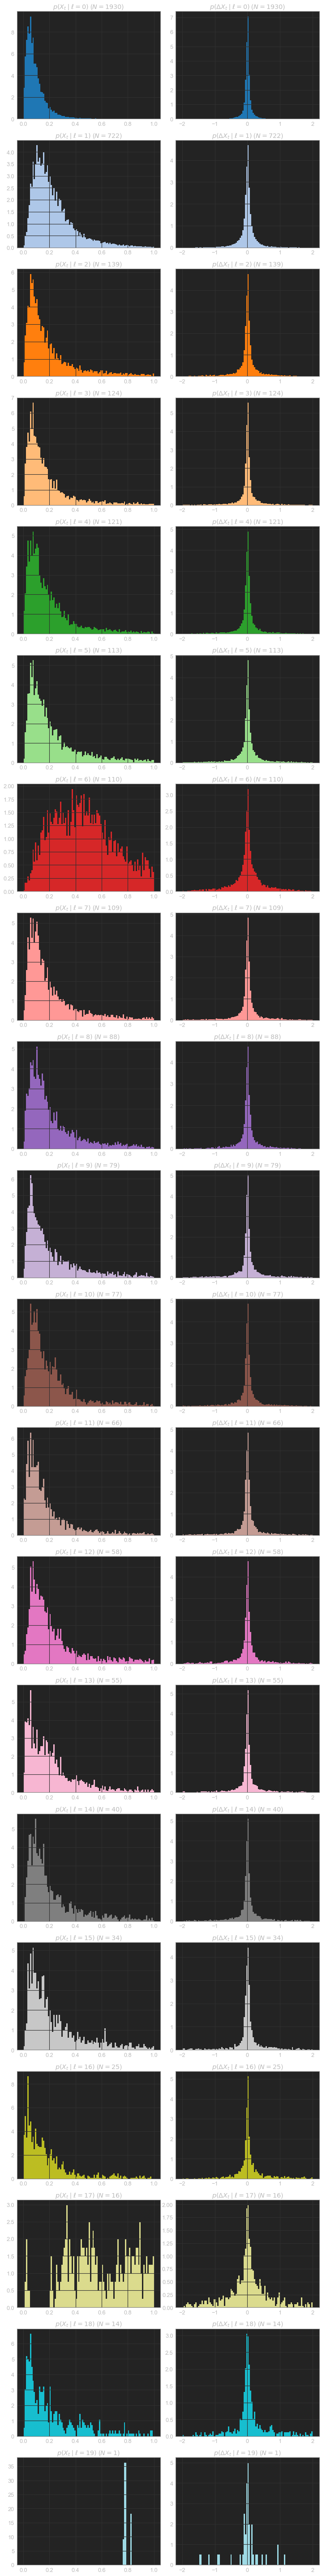

In [66]:
# setup plot
fig, dists = plt.subplots( len(ids), 2 )
fig.set_size_inches(10, len(ids)*4)

# plot the histograms
for kk in ids:
    #plt.scatter( freq.index[vals], freq[vals], c=[cmap[kk]], s=0.9 z
    for order in range(H):
        op = '\Delta ' * (order > 0) + f'^{order}'*(order>1)
        dists[kk,order].set_title(f'$p({op}X_t$ | $\ell={kk})$'
                                  f' ($N={cluster.loc[kk].N}$)')
        dists[kk,order].\
            hist((bins[order][1:]+bins[order][:-1])/2, bins=bins[order], 
                 weights=cluster.loc[kk,'hist'][order],
                 density=True, color=cmap[kk])
        pass

fig.tight_layout()
fig.savefig('dists.png')

# Below This Heading Is Not Done

### Evaluating the Sability of Clusters
As an indicator of how well the clusters cohere together outside of our restricted region, we'll track the total consumption for each sample path; then evaluate how well the groups stayed together over time.

#### Segmenting Consumption
First we'll compute the consumption totals for our region, and re-order our indcies so that the order corresponds to that of consumption.

In [102]:
xvals = np.arange(region.index.shape[0])

totals = region.\
    sum(axis=1).\
    sort_values()

perm = list(totals.index) # store permutation of 'id' column 
totals.set_axis(xvals, axis=0, inplace=True)


##### Next, plotting the consumption curve and highlighting the different clusters (along with centriod) we can see that the consumptions for members of the different clusters are grouped accordingly. This is to be expected, since consumption is a linear operator and acts on sample paths.

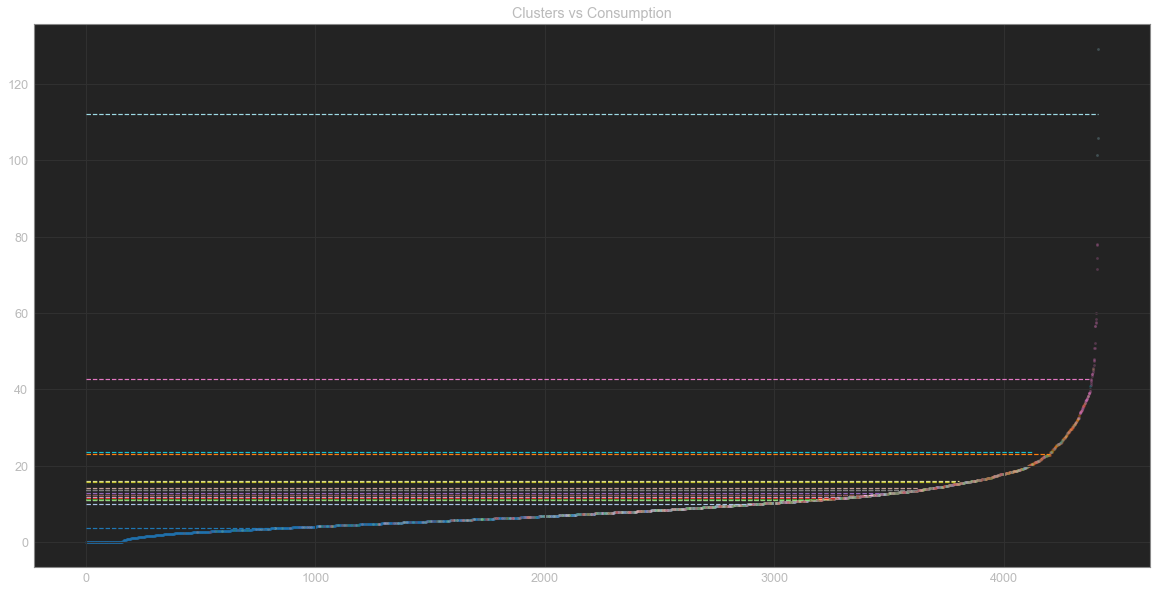

In [122]:
plt.figure(figsize=(20,10))
plt.title('Clusters vs Consumption')

for kk in ids:
    members = cluster.loc[kk].members
    xvs = np.array(list(map(perm.index, members)))
    
    # plot cluster with appropirate color
    plt.scatter(xvs, totals[xvs],
            color=[cmap[kk]], marker='o', s=6.5, alpha=0.25)
    
    # plot mean consumption for cluster`
    mu = totals[xvs].mean()
    plt.hlines( mu, 0, max(xvs[ totals[xvs] < mu ]), 
               linestyles='--', color=cmap[kk], alpha=1)

##### To test the stability of the clusters, we'll track consumption over the entire sample and look at how well our labels seperate these values.

In [181]:

# bin days
day_bins = data.index.map(
    lambda x : days[x.dayofyear-1])

# compute daily consumption curves
curv = 0.5*(data.fillna(0).groupby(day_bins).sum())

# set permute
curv.set_axis(labels, axis=1, inplace=True)


##### We are going to plot the daily consumption values, colored according to cluster, along with the relevant means.

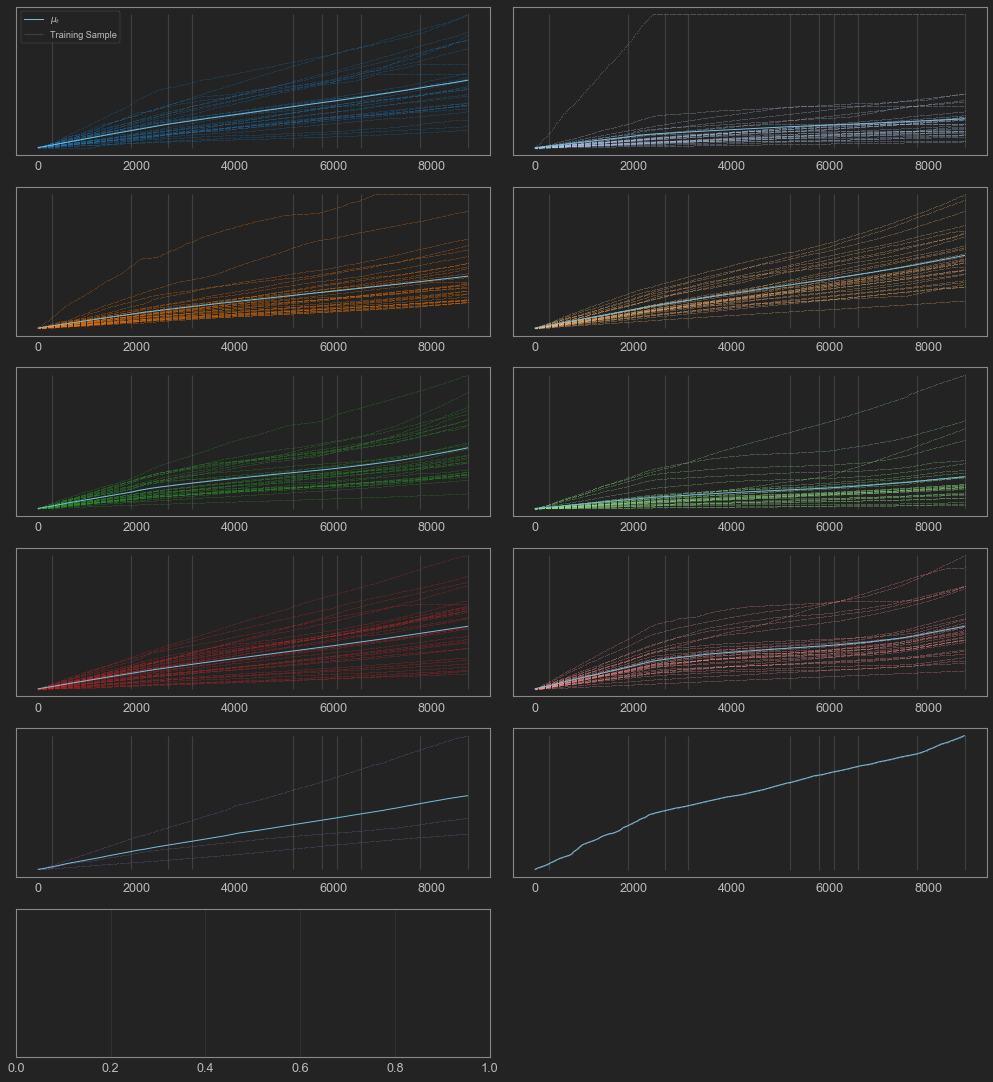

In [271]:
xv = pd.DataFrame([ [vv]*curv.columns.shape[0] for vv in curv.index], 
                  index=curv.index,
                  columns=curv.columns)

# a helper function to make this look easy
def plot_series_group(kk, legend=None, sample=None):
    global train_begin, train_end
    # get data for cluster 'kk'
    sums = pd.DataFrame(curv[kk].cumsum())
    try:
        sects = sums.sample(30, axis=1)
    except:
        sects = sums
        pass
    
    xv = pd.DataFrame([ [vv]*sects.columns.shape[0] 
                               for vv in sects.index], 
            index=sects.index,
            columns=sects.columns)
    # display training region
    #plt.axvspan(train_begin, train_end, 
    #                alpha=0.2, color='gray', 
    #            label='Training Region')    
    # plot sample path consumption sections 
    
    plt.vlines( samp, 0, sects.max().max(), 
                color='grey', label='Training Sample', alpha=0.3)
    plt.scatter(xv[kk], sects.values,
                s=1.0, c=[cmap[kk]], alpha=0.25)
    # plot mean-consumption for group
    plt.plot(sects.mean(axis=1), c='c', markersize=1.0, alpha=1.0,
             label="$\mu_t$", linewidth=1 )
    # if legend is non-nil add a legend.
    #legend and plt.legend(fontsize='x-small')
    plt.grid(False)
    pass

# begin plotting stuff
plt.figure(figsize=(14, 20))

# plot for group 0
kk = 0
plt.subplot(L,2,kk+1)
plt.yticks([])
plot_series_group(kk, legend=True)
plt.legend(fontsize='x-small')

for kk in range(1,K):
    # plot sample paths in group 'kk'
    try:
        plt.subplot(L, 2, kk+1)
        plt.yticks([])
        plot_series_group(kk)
    except:
        break
    
plt.tight_layout()




In [ ]:
plt.figure()

# cluster centers 
plt.subplot(1,2,1)
for kk in range(K):
    paths=sobolev.loc[labels==kk, :]
    mu = paths.mean() + 10 * kk
    plt.plot(mu.loc['2013'], c=cmap[kk])
    
# expected value of dmu
plt.subplot(1,2,2)
for kk in range(K):
    paths=sobolev.loc[labels==kk, :]
    mu = paths.mean() + 10 * kk
    plt.plot(mu.loc['2014'], c=cmap[kk])


In [ ]:
kobj.fit(dregion)

In [ ]:
H = kobj.cluster_centers_

In [ ]:
plt.figure()
for h in H:
    plt.plot(h);

In [ ]:
int_H = np.array([ 0.5*h.cumsum() for h in H])

labels = pd.Series(pairwise_distances_argmin(dregion, np.array([ 0.5*h.cumsum() for h in H])))

In [ ]:
plt.figure()
plt.plot(int_H.transpose().cumsum(axis=0))


In [ ]:
plt.figure()
samp = dregion.sample(100)
for ii in samp.index:
    plt.plot(region.loc[ii,:].cumsum())
    plt.plot(0.25*dregion.loc[ii,:].cumsum().cumsum())
